In [1]:
import os
import json
from pprint import pprint
from datetime import datetime
from collections import defaultdict

import chardet
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

vectorizer = TfidfVectorizer()

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/schilver/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/schilver/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloa

## Characterize News

In [2]:
NEWS_PATH = 'MC1/News Articles/'

def get_provider_id(provider_name):
    return provider_name.lower().replace(' ', '-')

news_providers = {get_provider_id(p): {'name': p} for p in os.listdir(NEWS_PATH) if os.path.isdir(os.path.join(NEWS_PATH, p))}

for p, v in news_providers.items():
    articles = [a for a in os.listdir(os.path.join(NEWS_PATH, v['name'])) if a.endswith('.txt')]
    v['nArticles'] = len(articles)
    v['articles'] = articles

print('News Providers')
pprint(news_providers)

News Providers
{'all-news-today': {'articles': ['698.txt',
                                 '714.txt',
                                 '77.txt',
                                 '612.txt',
                                 '603.txt',
                                 '617.txt',
                                 '341.txt',
                                 '237.txt',
                                 '753.txt',
                                 '154.txt',
                                 '554.txt',
                                 '391.txt',
                                 '420.txt',
                                 '152.txt',
                                 '135.txt',
                                 '121.txt',
                                 '251.txt',
                                 '683.txt'],
                    'nArticles': 18,
                    'name': 'All News Today'},
 'athena-speaks': {'articles': ['466.txt',
                                '270.txt',
                       

In [4]:
articles = []

date_parser_formats = ['%Y/%m/%d', '%d %B %Y']

def get_encoding(filepath):
    with open(filepath, 'rb') as f:
        return chardet.detect(f.read())['encoding']
    
def parse_date(date_str):
    for fmt in date_parser_formats:
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            pass
    return None

def process_text(text):
    # Get the list of stopwords
    stop_words = set(stopwords.words('english'))
    # Tokenize the text
    word_tokens = word_tokenize(text)
    # Initialize the WordNet Lemmatizer
    lemmatizer = WordNetLemmatizer()
    # Filter out the stopwords and lemmatize the remaining words
    processed_text = [
        lemmatizer.lemmatize(word) for word in word_tokens if word.lower() not in stop_words
    ]
    # Join the processed words and return the result
    return ' '.join(processed_text).lower()
    
def parse_article(filepath):
    encoding = get_encoding(filepath)
    article_lines = []
    location = None
    title = ''
    with open(filepath, 'r', encoding=encoding) as f:
        for line in f.readlines():
            line = line.strip()
            if line.startswith('SOURCE'):
                source = " ".join(line.split(':')[1:]).strip()
            elif line.startswith('TITLE'):
                title = " ".join(line.split(':')[1:]).strip()
            elif line.startswith('PUBLISHED'):
                date_str = line.split(':')[1].strip()
                published = parse_date(date_str)
            elif line.startswith('LOCATION'):
                location = line.split(':')[1].strip()
            elif len(line) > 0:
                article_lines.append(line)
    # Remove stopwords
    article = ' '.join(article_lines)
    parsed_article = process_text(article)
    return {
        'source': source,
        'title': title,
        'published': published,
        'location': location,
        'pure_text': article,
        'article': parsed_article,
        'filepath': filepath
    }

for p, v in news_providers.items():
    for a in v['articles']:
        filepath = os.path.join(NEWS_PATH, v['name'], a)
        encoding = get_encoding(filepath)
        with open(filepath, 'r', encoding=encoding) as f:
            try:
                article = parse_article(filepath)
            except Exception as e:
                raise Exception(f'Error parsing article {filepath}: {e}')
            article['provider'] = p
            articles.append(article)

In [5]:
df = pd.DataFrame(articles)
df.head()

,source,title,published,location,pure_text,article,filepath,provider
0,The Wrap,POK REMIND LEADER MARTYRED,2012-06-21,"ABILA, Kronos",In LEADERs of moving ceramics Wednesday of act...,leaders moving ceramic wednesday activist grou...,MC1/News Articles/The Wrap/116.txt,the-wrap
1,The Wrap,THE END OF PROTESTS POK IN ARRESTS,2005-04-06,"ELODIS, Kronos",Fifteen members of the guards of Kronos the ac...,fifteen member guard kronos activist organizat...,MC1/News Articles/The Wrap/17.txt,the-wrap
2,The Wrap,DEMONSTRATION ATTRACTS THOUSANDS IN SPITE OF RAIN,2012-11-12,"ABILA, Kronos",A heavy rain loved no thousands of citizens in...,heavy rain loved thousand citizen insuring vot...,MC1/News Articles/The Wrap/843.txt,the-wrap
3,The Wrap,A CELEBRATION OF DELIVERED KLEPTOCRACY,2014-01-19,"ABILA, Kronos",After annual gAStech-Kronos the collective sta...,annual gastech-kronos collective staff employe...,MC1/News Articles/The Wrap/704.txt,the-wrap
4,The Wrap,THE SHEET OF THE PUBLIC HEALTH ELODIS - UPDATE,2000-06-02,"ELODIS, Kronos",The environment impact of the Hyper Acidic has...,environment impact hyper acidic disposal subst...,MC1/News Articles/The Wrap/271.txt,the-wrap


In [6]:
def compound_sentiments(sentiments):
    sentiment_scores = defaultdict(lambda : 0.0)
    for sentiment in sentiments:
        label = sentiment['label']
        score = sentiment['score']
        sentiment_scores[label] += score
    sentiment_scores = [(-v, l) for l, v in sentiment_scores.items()]
    sentiment_scores.sort()
    return sentiment_scores[0][1]

def get_sentiment(text, chunk_size=400):
    if chunk_size < 100:
        print(f'Error getting sentiment for text: {text}. Chunk size cannot be decreased to less than 100.')
        return None
    words = text.split(' ')
    chunks = []
    while len(words) >= chunk_size:
        chunk = words[:chunk_size]
        chunks.append(' '.join(chunk))
        words = words[chunk_size:]
    chunks.append(' '.join(words))
    try:
        sentiments = sentiment_pipeline(chunks)
    except Exception as e:
        print(f'Warn: Getting sentiment for text: {text}. Decreasing chunk size to {chunk_size-100} and trying again.')
        return get_sentiment(text, chunk_size=chunk_size-100)
    sentiment = compound_sentiments(sentiments)
    return sentiment

text = "I love you"
get_sentiment(text)

'positive'

In [7]:
data = df.article.apply(lambda x: get_sentiment(x))
df['sentiment'] = data
df.head()

,source,title,published,location,pure_text,article,filepath,provider,sentiment
0,The Wrap,POK REMIND LEADER MARTYRED,2012-06-21,"ABILA, Kronos",In LEADERs of moving ceramics Wednesday of act...,leaders moving ceramic wednesday activist grou...,MC1/News Articles/The Wrap/116.txt,the-wrap,neutral
1,The Wrap,THE END OF PROTESTS POK IN ARRESTS,2005-04-06,"ELODIS, Kronos",Fifteen members of the guards of Kronos the ac...,fifteen member guard kronos activist organizat...,MC1/News Articles/The Wrap/17.txt,the-wrap,neutral
2,The Wrap,DEMONSTRATION ATTRACTS THOUSANDS IN SPITE OF RAIN,2012-11-12,"ABILA, Kronos",A heavy rain loved no thousands of citizens in...,heavy rain loved thousand citizen insuring vot...,MC1/News Articles/The Wrap/843.txt,the-wrap,neutral
3,The Wrap,A CELEBRATION OF DELIVERED KLEPTOCRACY,2014-01-19,"ABILA, Kronos",After annual gAStech-Kronos the collective sta...,annual gastech-kronos collective staff employe...,MC1/News Articles/The Wrap/704.txt,the-wrap,positive
4,The Wrap,THE SHEET OF THE PUBLIC HEALTH ELODIS - UPDATE,2000-06-02,"ELODIS, Kronos",The environment impact of the Hyper Acidic has...,environment impact hyper acidic disposal subst...,MC1/News Articles/The Wrap/271.txt,the-wrap,neutral


In [8]:
data = df.title.apply(lambda x: get_sentiment(x))
df['title_sentiment'] = data
df.head()

,source,title,published,location,pure_text,article,filepath,provider,sentiment,title_sentiment
0,The Wrap,POK REMIND LEADER MARTYRED,2012-06-21,"ABILA, Kronos",In LEADERs of moving ceramics Wednesday of act...,leaders moving ceramic wednesday activist grou...,MC1/News Articles/The Wrap/116.txt,the-wrap,neutral,neutral
1,The Wrap,THE END OF PROTESTS POK IN ARRESTS,2005-04-06,"ELODIS, Kronos",Fifteen members of the guards of Kronos the ac...,fifteen member guard kronos activist organizat...,MC1/News Articles/The Wrap/17.txt,the-wrap,neutral,negative
2,The Wrap,DEMONSTRATION ATTRACTS THOUSANDS IN SPITE OF RAIN,2012-11-12,"ABILA, Kronos",A heavy rain loved no thousands of citizens in...,heavy rain loved thousand citizen insuring vot...,MC1/News Articles/The Wrap/843.txt,the-wrap,neutral,neutral
3,The Wrap,A CELEBRATION OF DELIVERED KLEPTOCRACY,2014-01-19,"ABILA, Kronos",After annual gAStech-Kronos the collective sta...,annual gastech-kronos collective staff employe...,MC1/News Articles/The Wrap/704.txt,the-wrap,positive,neutral
4,The Wrap,THE SHEET OF THE PUBLIC HEALTH ELODIS - UPDATE,2000-06-02,"ELODIS, Kronos",The environment impact of the Hyper Acidic has...,environment impact hyper acidic disposal subst...,MC1/News Articles/The Wrap/271.txt,the-wrap,neutral,neutral


In [9]:
tfidf_matrix = vectorizer.fit_transform(df.article).toarray()
tfidf_df = pd.DataFrame(tfidf_matrix, columns=vectorizer.get_feature_names_out())

# Delete Number Columns
for c in tfidf_df.columns:
    if c[0].isnumeric():
        del tfidf_df[c]

tfidf_df.head()

,aandacht,abandonment,abducted,abduction,abila,abilia,abilians,ability,ablaze,able,...,youth,zeal,zeeschaliegas,zero,zoeken,zoekende,zone,zoon,zowat,éramos
0,0.0,0.0,0.0,0.0,0.025424,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.051303,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


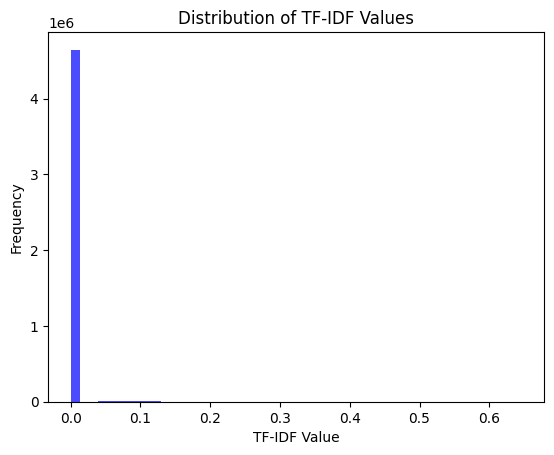

0.01430969431649995


In [10]:
# Assuming `tfidf_df` is your DataFrame with TF-IDF values
tfidf_values = tfidf_df.values.flatten()

# Plotting the distribution of TF-IDF values
plt.hist(tfidf_values, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of TF-IDF Values')
plt.xlabel('TF-IDF Value')
plt.ylabel('Frequency')
plt.show()

# Calculating descriptive statistics
mean_tfidf = tfidf_values.mean()
std_tfidf = tfidf_values.std()

# Setting a threshold value
threshold = mean_tfidf + std_tfidf 
print(threshold)

In [11]:
def get_dict(x):
    tfidf = [(k, v) for k, v in x.items() if v > threshold]
    tfidf.sort(key=lambda x: x[1], reverse=True)
    tfidf_dict = json.dumps(dict(tfidf))
    return tfidf_dict

tfidf_series = tfidf_df.apply(lambda x: get_dict(x), axis=1)
tfidf_series.head()

0    {"elian": 0.3735671589159742, "paid": 0.186504...
1    {"song": 0.26743046087642364, "facility": 0.23...
2    {"person": 0.23552061843960478, "citizen": 0.1...
3    {"kronos": 0.2532382983088051, "servant": 0.23...
4    {"peaks": 0.1774332758629429, "vinegar": 0.177...
dtype: object

In [12]:
df['tfidf'] = tfidf_series
df.head()

,source,title,published,location,pure_text,article,filepath,provider,sentiment,title_sentiment,tfidf
0,The Wrap,POK REMIND LEADER MARTYRED,2012-06-21,"ABILA, Kronos",In LEADERs of moving ceramics Wednesday of act...,leaders moving ceramic wednesday activist grou...,MC1/News Articles/The Wrap/116.txt,the-wrap,neutral,neutral,"{""elian"": 0.3735671589159742, ""paid"": 0.186504..."
1,The Wrap,THE END OF PROTESTS POK IN ARRESTS,2005-04-06,"ELODIS, Kronos",Fifteen members of the guards of Kronos the ac...,fifteen member guard kronos activist organizat...,MC1/News Articles/The Wrap/17.txt,the-wrap,neutral,negative,"{""song"": 0.26743046087642364, ""facility"": 0.23..."
2,The Wrap,DEMONSTRATION ATTRACTS THOUSANDS IN SPITE OF RAIN,2012-11-12,"ABILA, Kronos",A heavy rain loved no thousands of citizens in...,heavy rain loved thousand citizen insuring vot...,MC1/News Articles/The Wrap/843.txt,the-wrap,neutral,neutral,"{""person"": 0.23552061843960478, ""citizen"": 0.1..."
3,The Wrap,A CELEBRATION OF DELIVERED KLEPTOCRACY,2014-01-19,"ABILA, Kronos",After annual gAStech-Kronos the collective sta...,annual gastech-kronos collective staff employe...,MC1/News Articles/The Wrap/704.txt,the-wrap,positive,neutral,"{""kronos"": 0.2532382983088051, ""servant"": 0.23..."
4,The Wrap,THE SHEET OF THE PUBLIC HEALTH ELODIS - UPDATE,2000-06-02,"ELODIS, Kronos",The environment impact of the Hyper Acidic has...,environment impact hyper acidic disposal subst...,MC1/News Articles/The Wrap/271.txt,the-wrap,neutral,neutral,"{""peaks"": 0.1774332758629429, ""vinegar"": 0.177..."


In [13]:
df.to_pickle('data/news_articles.pkl')
df.to_csv('data/news_articles.csv', index=False)
df.to_excel('data/news_articles.xlsx', index=False)

In [15]:
df = pd.read_pickle('data/news_articles.pkl')
df.head()

,source,title,published,location,pure_text,article,filepath,provider,sentiment,tfidf
0,The Wrap,POK REMIND LEADER MARTYRED,2012-06-21,"ABILA, Kronos",In LEADERs of moving ceramics Wednesday of act...,leaders moving ceramic wednesday activist grou...,MC1/News Articles/The Wrap/116.txt,the-wrap,neutral,"{""elian"": 0.3735671589159742, ""paid"": 0.186504..."
1,The Wrap,THE END OF PROTESTS POK IN ARRESTS,2005-04-06,"ELODIS, Kronos",Fifteen members of the guards of Kronos the ac...,fifteen member guard kronos activist organizat...,MC1/News Articles/The Wrap/17.txt,the-wrap,neutral,"{""song"": 0.26743046087642364, ""facility"": 0.23..."
2,The Wrap,DEMONSTRATION ATTRACTS THOUSANDS IN SPITE OF RAIN,2012-11-12,"ABILA, Kronos",A heavy rain loved no thousands of citizens in...,heavy rain loved thousand citizen insuring vot...,MC1/News Articles/The Wrap/843.txt,the-wrap,neutral,"{""person"": 0.23552061843960478, ""citizen"": 0.1..."
3,The Wrap,A CELEBRATION OF DELIVERED KLEPTOCRACY,2014-01-19,"ABILA, Kronos",After annual gAStech-Kronos the collective sta...,annual gastech-kronos collective staff employe...,MC1/News Articles/The Wrap/704.txt,the-wrap,positive,"{""kronos"": 0.2532382983088051, ""servant"": 0.23..."
4,The Wrap,THE SHEET OF THE PUBLIC HEALTH ELODIS - UPDATE,2000-06-02,"ELODIS, Kronos",The environment impact of the Hyper Acidic has...,environment impact hyper acidic disposal subst...,MC1/News Articles/The Wrap/271.txt,the-wrap,neutral,"{""peaks"": 0.1774332758629429, ""vinegar"": 0.177..."
